In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime as dt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

2023-11-19 05:00:29.041399: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-19 05:00:29.041521: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-19 05:00:29.041564: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-19 05:00:29.056178: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-19 05:00:30.365115: W tensorflow/compiler/

In [2]:
df = pd.read_csv("../data/model_data/mbank_deposits_2012_2023.csv", sep=";") # wartosci stóp procentowych
df2 = pd.read_excel("../data/model_data/akcje_mbank.xlsx") # wartosci akcji i wolumenu
df3 = pd.read_excel("../data/model_data/bezrobocie.xlsx") # wartosci bezrobocia

In [3]:
dates = [dt.datetime(year, month, 1) for year, month in zip(df["year"], df["month"])]

In [4]:
df["Date"] = dates

In [5]:
# fill missing days in df
df = df.set_index("Date")
idx = pd.date_range(df.index.min(), df.index.max())
df = df.reindex(idx, fill_value=np.nan)
df = df.reset_index()
df.rename(columns={"index": "Date"}, inplace=True)
df.drop(columns=["year", "month"], inplace=True)
df["3_months"] = df["3_months"].interpolate()
df["6_months"] = df["6_months"].interpolate()

In [6]:
df2["Date"] = pd.to_datetime(df2["Date"])
df2 = df2.set_index("Date")
idx = pd.date_range(df2.index.min(), df2.index.max())
df2 = df2.reindex(idx, fill_value=np.nan)
df2 = df2.reset_index()
df2.rename(columns={"index": "Date"}, inplace=True)
df2["Close"] = df2["Close"].ffill()
df2["Volume"] = df2["Volume"].ffill()
df2["Date"] = df2["Date"].dt.date
df2["Date"] = pd.to_datetime(df2["Date"])

In [7]:
df3["Data"] = pd.to_datetime(df3["Data"])
df3 = df3.set_index("Data")
idx = pd.date_range(df3.index.min(), df3.index.max())
df3 = df3.reindex(idx, fill_value=np.nan)
df3 = df3.reset_index()
df3.rename(columns={"index": "Date"}, inplace=True)
df3["Stopa"] = df3["Stopa"].interpolate()
df3["Date"] = df3["Date"].dt.date
df3["Date"] = pd.to_datetime(df3["Date"])

In [8]:
# merging into one df
df = df.merge(df2, on="Date", how="left").merge(df3, on="Date", how="left").dropna()

In [9]:
n1 = int(0.8 * len(df))
n2 = int(0.9 * len(df))

In [10]:
df.drop(columns=["Date", "6_months"], inplace=True)

In [11]:
df.columns

Index(['3_months', 'Close', 'Volume', 'Stopa'], dtype='object')

In [12]:
df_train = df.iloc[:n1, :]

## Preprocessing

In [13]:
scaler = MinMaxScaler()
scaler.fit(df_train["3_months"].values.reshape(-1, 1))
df["3_months"] = scaler.transform(df["3_months"].values.reshape(-1, 1))

In [14]:
scaler = StandardScaler()
scaler.fit(df_train["Close"].values.reshape(-1, 1))
df["Close"] = scaler.transform(df["Close"].values.reshape(-1, 1))

In [15]:
scaler = StandardScaler()
scaler.fit(np.log(df_train["Volume"]).values.reshape(-1, 1))
df["Volume"] = scaler.transform(np.log(df["Volume"]).values.reshape(-1, 1))

In [16]:
scaler = MinMaxScaler()
scaler.fit(df_train["Stopa"].values.reshape(-1, 1))
df["Stopa"] = scaler.transform(df["Stopa"].values.reshape(-1, 1))

In [17]:
BLOCK_SIZE = 16 

In [18]:
df["target"] = df["3_months"].shift(-1)

In [19]:
for i in range(1, BLOCK_SIZE):
    df[f"3_months_{i}"] = df["3_months"].shift(i)
    df[f"Close_{i}"] = df["Close"].shift(i)
    df[f"Volume_{i}"] = df["Volume"].shift(i)
    df[f"Stopa_{i}"] = df["Stopa"].shift(i)

In [20]:
df.dropna(inplace=True)

In [21]:
df_train = df.iloc[:n1, :]
df_val = df.iloc[n1:n2, :]
df_test = df.iloc[n2:, :]

In [22]:
x_train = df_train.drop(columns=["target"]).values.reshape(-1, BLOCK_SIZE, 4)
y_train = df_train["target"].values
x_val = df_val.drop(columns=["target"]).values.reshape(-1, BLOCK_SIZE, 4)
y_val = df_val["target"].values
x_test = df_test.drop(columns=["target"]).values.reshape(-1, BLOCK_SIZE, 4)
y_test = df_test["target"].values

## Transformer Components

In [43]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, d_model):
        super().__init__()
        self.lstm_embed = tf.keras.layers.LSTM(d_model, return_sequences=True)
        self.pos_encoding = tf.keras.layers.Embedding(100, d_model)

    def call(self, x):
        x_pos = self.pos_encoding(x.shape[1])
        x = self.lstm_embed(x)
        x = x + x_pos
        return x

In [44]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

In [45]:
class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [46]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model),
            tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x) 
        return x

In [47]:
class DecoderBlock(tf.keras.layers.Layer):
    def __init__(self,
                d_model,
                num_heads,
                dff,
                dropout_rate=0.1):
        super(DecoderBlock, self).__init__()

        self.causal_self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.causal_self_attention(x=x)
        x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
        return x

In [48]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, dropout_rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(d_model=d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_blocks = [
            DecoderBlock(d_model=d_model, num_heads=num_heads,
                        dff=dff, dropout_rate=dropout_rate)
            for _ in range(num_layers)]

    def call(self, x):
        x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)
        x = self.dropout(x)
        for block in self.dec_blocks:
            x = block(x)
        # The shape of x is (batch_size, target_seq_len, d_model).
        return x

In [49]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads,
                dropout_rate=0.1):
        super().__init__()
        self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                            num_heads=num_heads, dff=4*d_model,
                            dropout_rate=dropout_rate)

        self.final_layer = tf.keras.layers.Dense(1, activation="sigmoid")

    def call(self, inputs):
        x = self.decoder(inputs) # (batch_size, target_len, d_model)
        x = x[:, -1, :]
        logits = self.final_layer(x)  # (batch_size, 1, target_vocab_size)
        return logits

In [50]:
model = Transformer(num_layers=4, d_model=128, num_heads=4)

In [51]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0004),
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=["mae"])

In [52]:
# training
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/50


2023-11-19 05:03:47.724265: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fe2bc1850b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-19 05:03:47.724331: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 with Max-Q Design, Compute Capability 7.5
2023-11-19 05:03:47.731683: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-19 05:03:47.856973: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


95/95 [==============================] - 24s 82ms/step - loss: 0.0420 - mae: 0.1243 - val_loss: 0.0062 - val_mae: 0.0737
Epoch 2/50
95/95 [==============================] - 6s 67ms/step - loss: 0.0014 - mae: 0.0280 - val_loss: 0.0079 - val_mae: 0.0829
Epoch 3/50
95/95 [==============================] - 6s 65ms/step - loss: 9.5160e-04 - mae: 0.0229 - val_loss: 0.0078 - val_mae: 0.0833
Epoch 4/50
95/95 [==============================] - 7s 69ms/step - loss: 6.6692e-04 - mae: 0.0195 - val_loss: 0.0059 - val_mae: 0.0722
Epoch 5/50
95/95 [==============================] - 7s 72ms/step - loss: 4.1659e-04 - mae: 0.0154 - val_loss: 0.0057 - val_mae: 0.0702
Epoch 6/50
95/95 [==============================] - 6s 67ms/step - loss: 3.6012e-04 - mae: 0.0143 - val_loss: 0.0073 - val_mae: 0.0811
Epoch 7/50
95/95 [==============================] - 6s 65ms/step - loss: 4.1286e-04 - mae: 0.0153 - val_loss: 0.0053 - val_mae: 0.0694
Epoch 8/50
95/95 [==============================] - 6s 63ms/step - loss: 

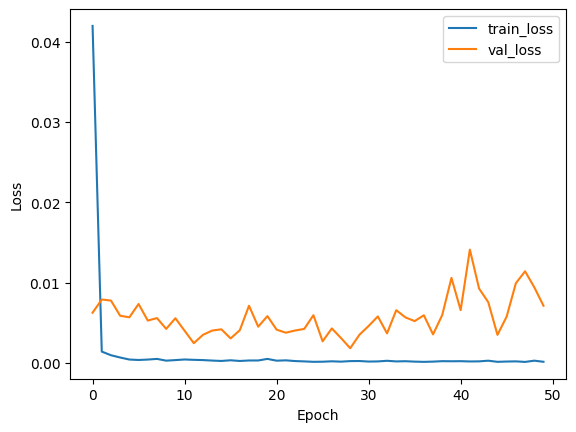

In [54]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

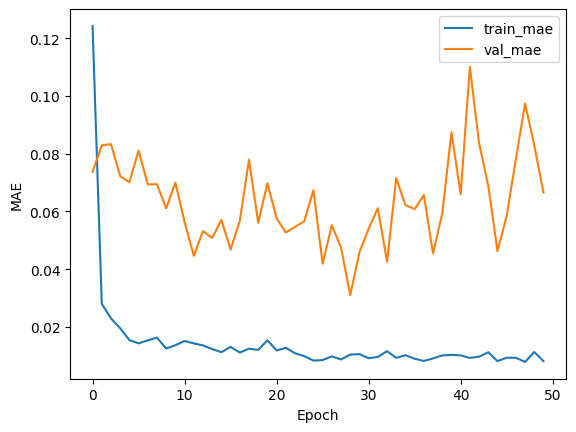

In [55]:
plt.plot(history.history["mae"], label="train_mae")
plt.plot(history.history["val_mae"], label="val_mae")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.show()